In [1]:
import numpy as np
import optuna
from dask.distributed import Client, wait
from optuna.integration.dask import DaskStorage
import sys
sys.path.insert(1, 'bin/capstonecompetition/')
from capstone import CapstoneObjective
from capvisual import CapstoneVisual
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Function 7: **Sometimes Lazy is Best.** You are now optimizing six hyper-parameters of a machine learning model. Note that it is a popular and frequently used model, so maybe you could search to see if anyone else has optimized it before?

### 1. Setup Environment

In [2]:
# Cluster URL - set to None if using just a local client
GLBL_dask_cluster_url = 'tcp://10.0.4.87:8786'
#GLBL_dask_cluster_url = None
GLBL_dask_n_futures = 100
GLBL_dask_upload_file = 'bin/capstonecompetition/capstone.py'
GLBL_optuna_n_trials = 20
GLBL_optuna_study_name = 'f7_GaussianProcessRegressor'
GLBL_optuna_direction = ["maximize", "minimize", "maximize"]
GLBL_optuna_storage = 'mysql://test@localhost/optuna'

# Load the data
X = np.load('update_data/function_7/update_inputs.npy')
Y = np.load('update_data/function_7/update_outputs.npy')

# Load the capstone objective function
optrun = CapstoneObjective(X, Y, 7)

# Load the best observation in case we need it here...
observation_x = optrun.get_best_observe_x()

# Set up a basic grid for the function
X_grid = optrun.get_grid_for_func()

### 2. Visualize the latest Data

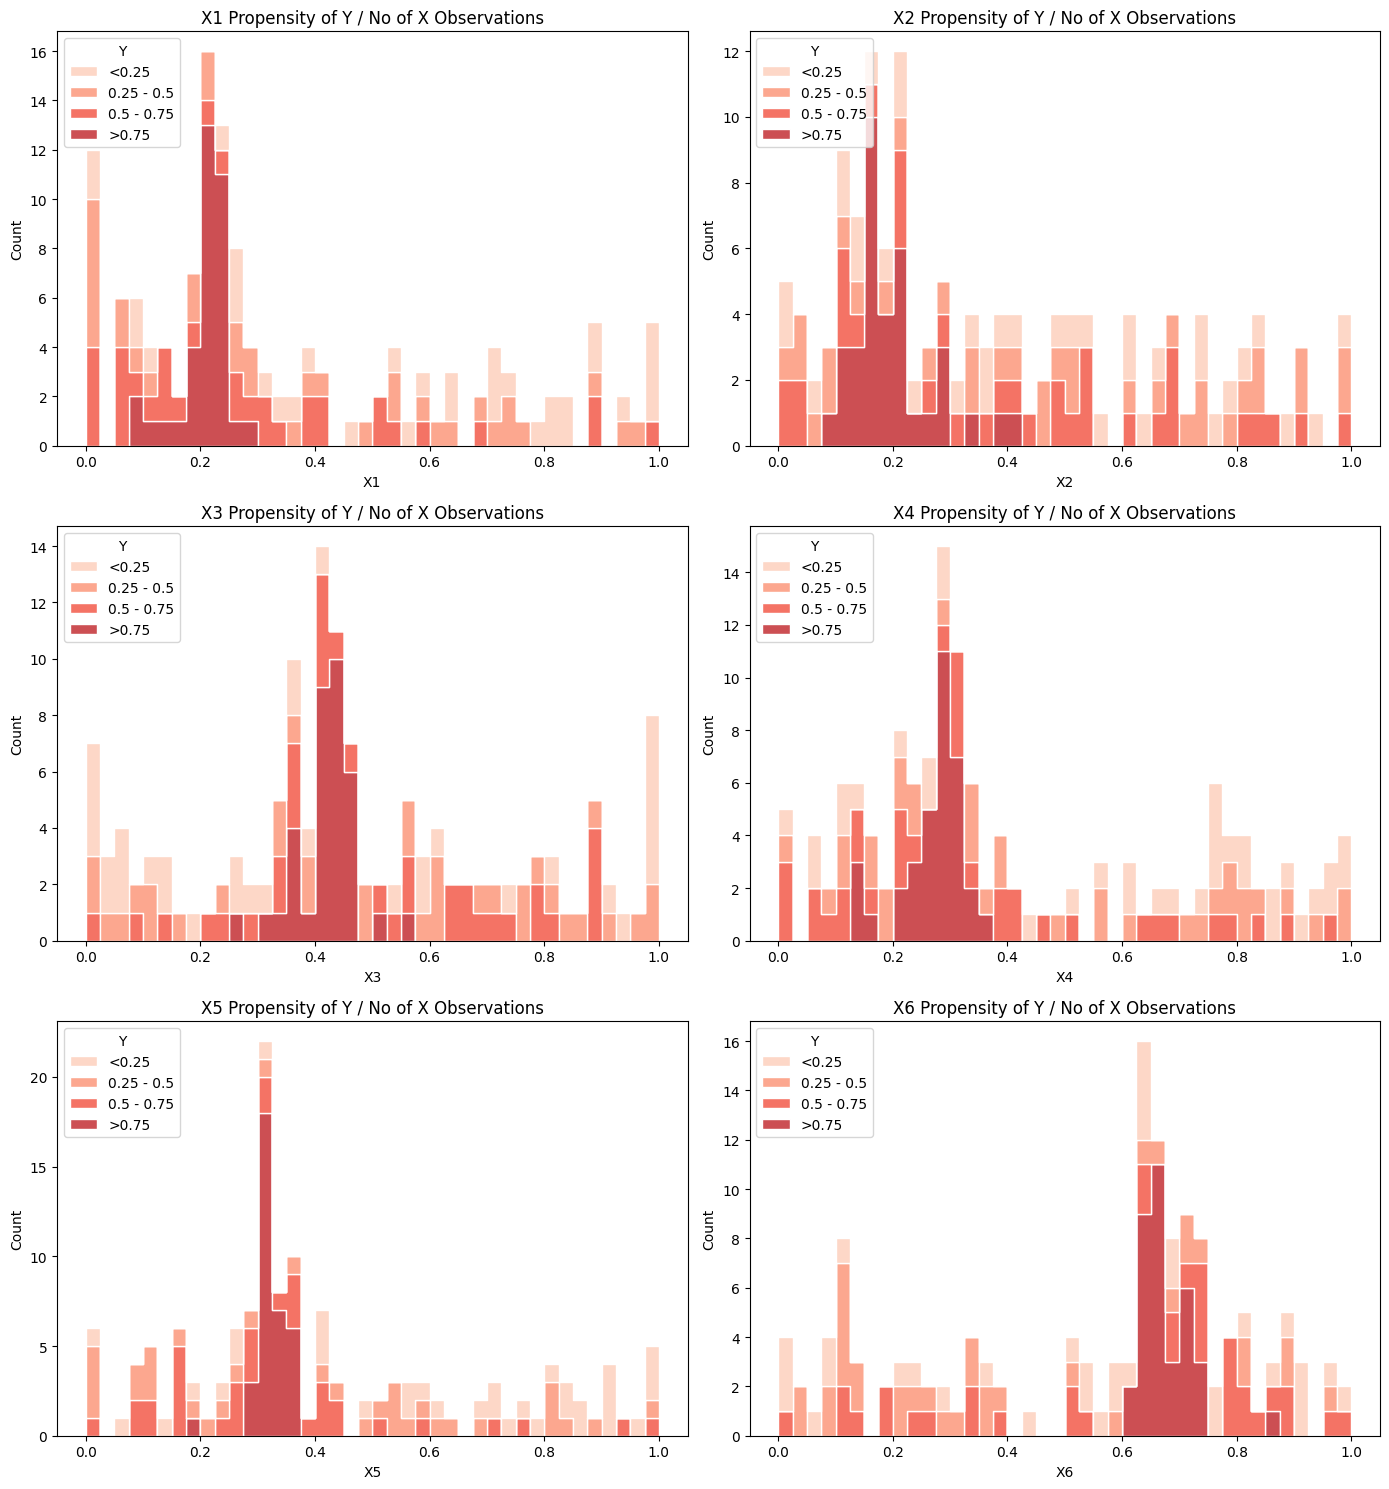

In [3]:
# Create another object for visualisation (not pickled in the cluster)
optview = CapstoneVisual(optrun)
optview.plot_distribution()

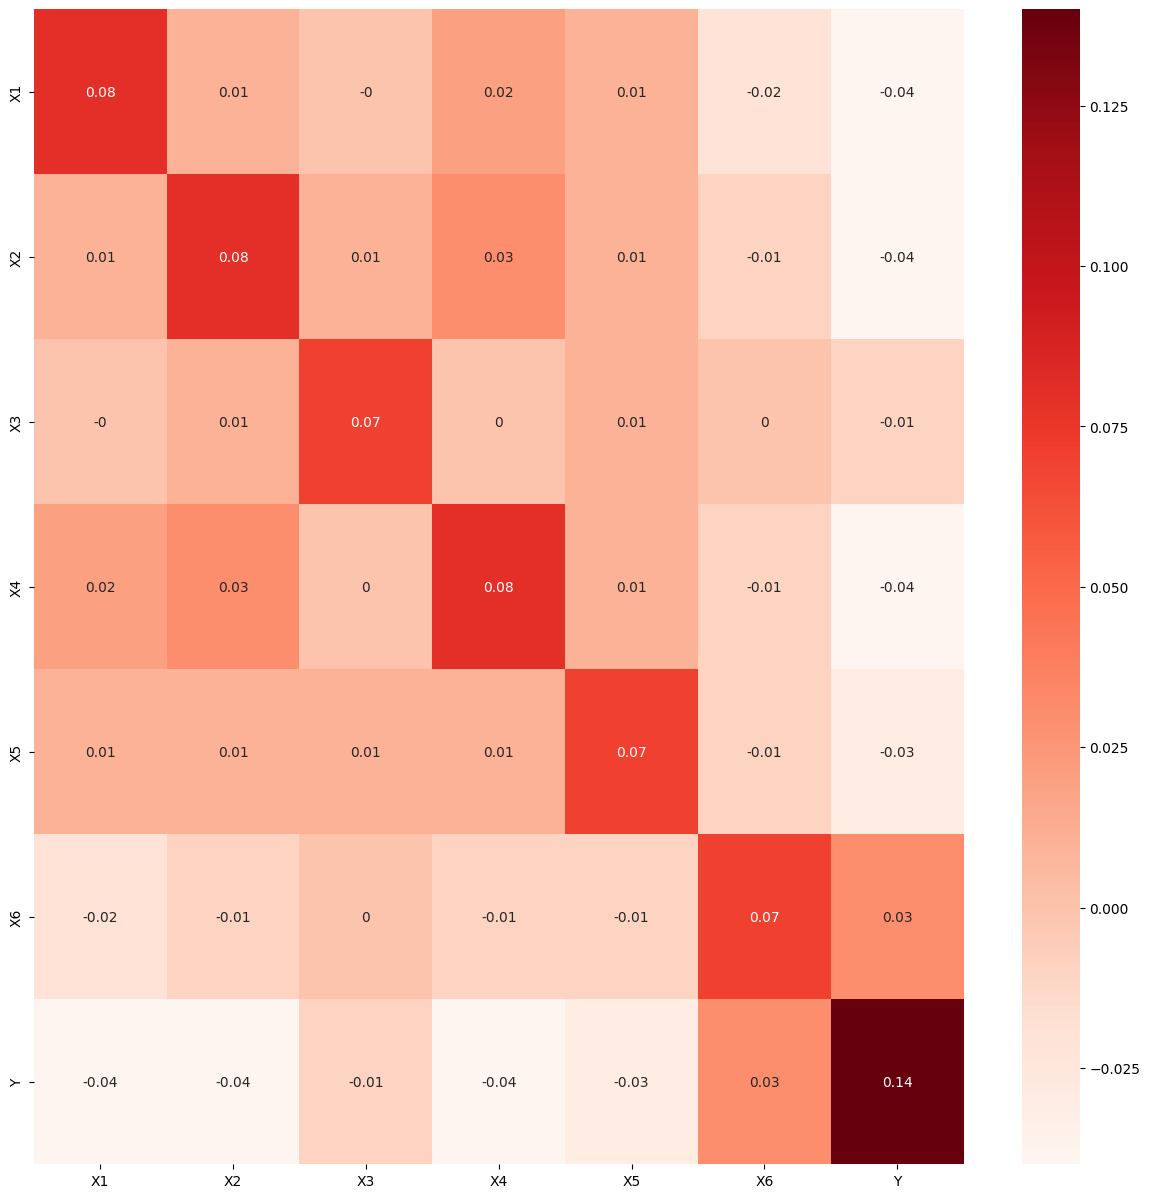

In [4]:
optview.plot_covariance()

In [5]:
optview.return_parellelmap()

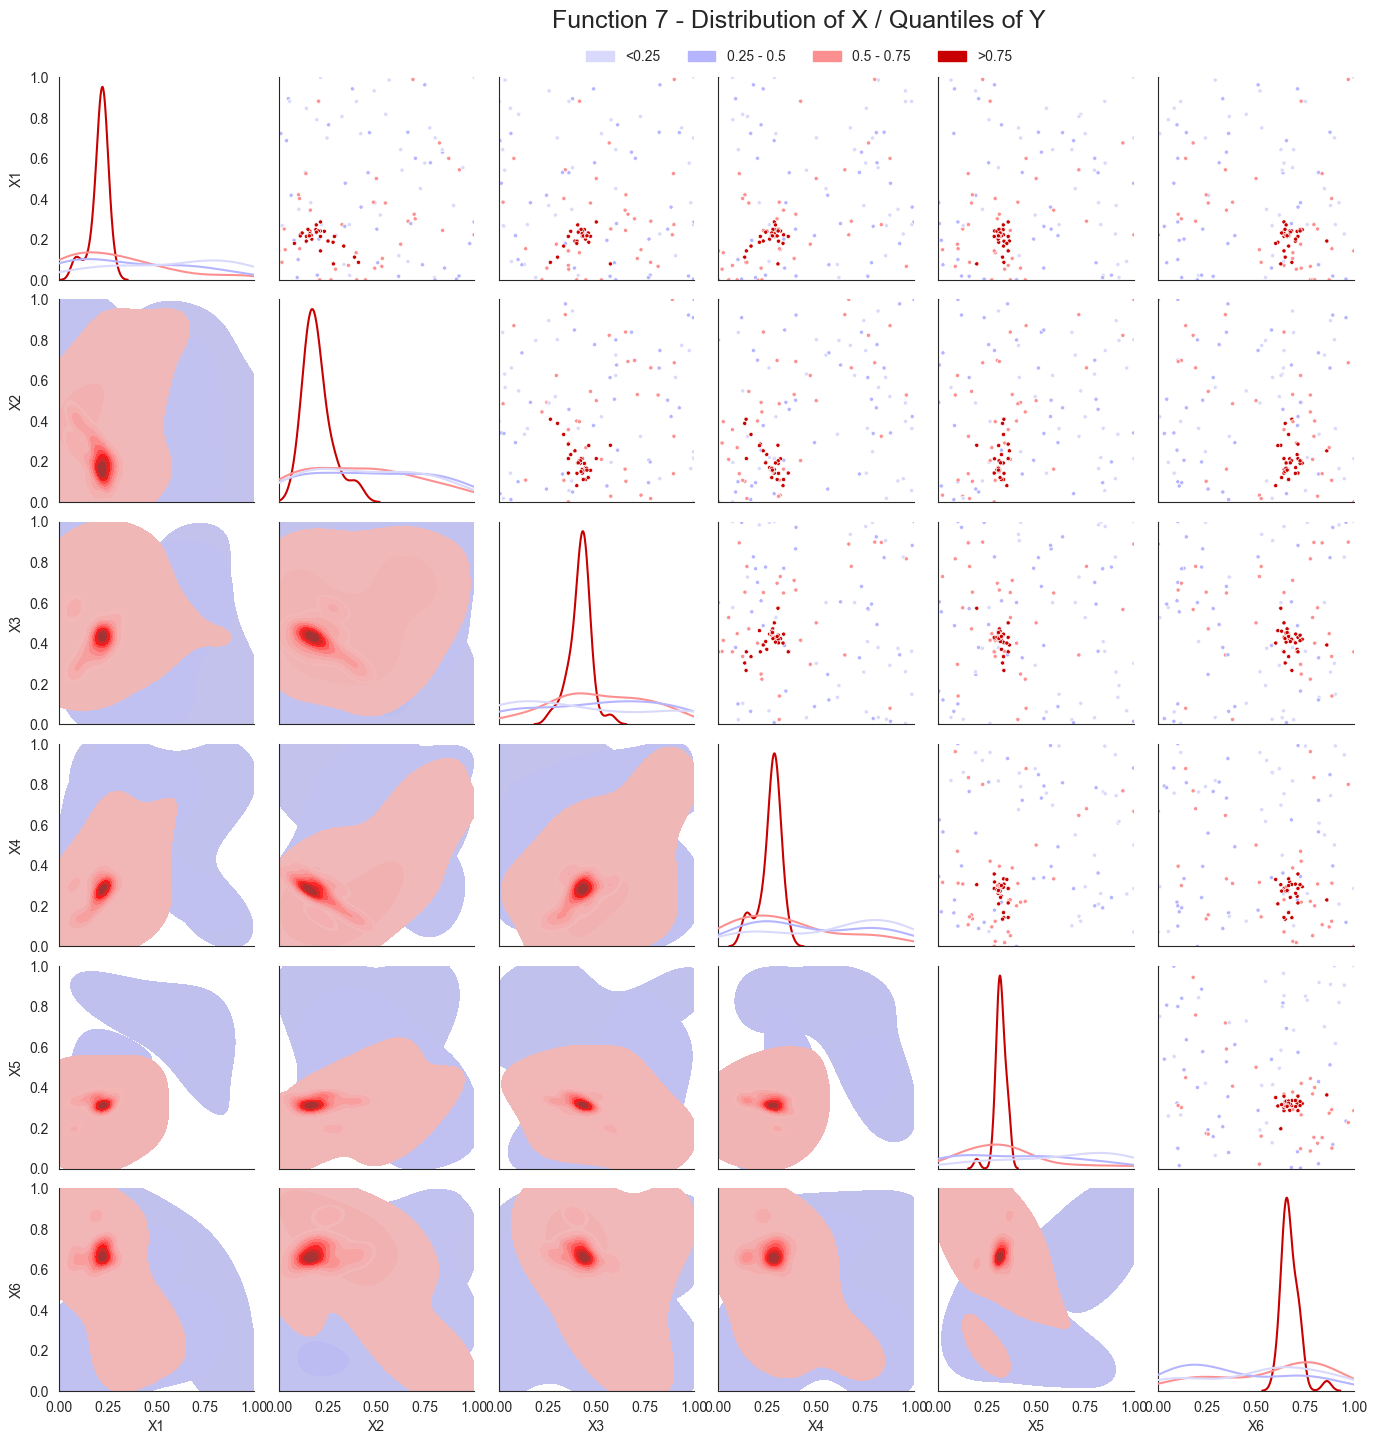

In [6]:
optview.return_scatterpairplot()

In [7]:
df = optview.return_as_pandas()
df.sort_values(by='Y', ascending=False).head(10)

X1        X2        X3        X4        X5        X6             Y
133  0.215055  0.156395  0.470335  0.277514  0.312339  0.658909  3.3192764125
137  0.217215  0.157590  0.452435  0.276118  0.307239  0.659013  3.3132610904
130  0.215847  0.159363  0.447721  0.276331  0.307725  0.662010  3.3109959618
136  0.220000  0.166667  0.450000  0.273333  0.306667  0.653333  3.3074719443
129  0.220000  0.166667  0.450000  0.273333  0.306667  0.653333  3.3074719443
126  0.216539  0.157413  0.441369  0.271248  0.307999  0.661977  3.3068935365
122  0.227936  0.160435  0.427757  0.285524  0.313683  0.644186  3.2868963086
135  0.231378  0.120687  0.459011  0.272859  0.315559  0.630809  3.2805887650
114  0.240000  0.160000  0.430000  0.280000  0.300000  0.643333  3.2769823022
123  0.249387  0.150403  0.422445  0.278859  0.309998  0.648131  3.2731964823

### 3. Hyperparameter Optimization over the Dask Cluster

In [8]:
# Build a Dask Client
client = Client(GLBL_dask_cluster_url)
client.upload_file(GLBL_dask_upload_file)
storage = DaskStorage(client=client)

# Build the Optuna study
study = optuna.create_study(storage=storage, study_name=GLBL_optuna_study_name, directions=GLBL_optuna_direction)

# Build the futures for the Dask Client
futures = [
    client.submit(study.optimize, optrun, n_trials=GLBL_optuna_n_trials, pure=False)
    for _ in range(GLBL_dask_n_futures)
]

# Run the Dask futures
client.gather(futures)
wait(futures)
client.cancel(futures)

/var/folders/0x/s197kd456h5gfsxy568y34p00000gn/T/ipykernel_78008/3240579904.py:4: ExperimentalWarning:

DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.



In [9]:
# Return the study findings
optrun.get_studyresults(study)

Choosen Trial: 
	_number: 1478
	state: 1
	_values: [62.150681789365706, 0.14883653919265047, 0.9829691104185155]
	_datetime_start: 2024-04-14 14:38:21.638666
	datetime_complete: 2024-04-14 14:38:45.212150
	_params: {'kernel': 'sineexp', 'f_sine_lbound': 0.0001, 'f_sine_rbound': 100.0, 'f_sine_lscale': 0.524238142418362, 'f_sine_p': 3.036493291510278}
	_user_attrs: {}
	_system_attrs: {'nsga2:generation': 19}
	intermediate_values: {}
	_distributions: {'kernel': CategoricalDistribution(choices=('rbf', 'rbf-white', 'const', 'quad', 'matern', 'sineexp')), 'f_sine_lbound': CategoricalDistribution(choices=(1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1)), 'f_sine_rbound': CategoricalDistribution(choices=(10000000.0, 1000000.0, 100000.0, 10000.0, 1000.0, 100.0, 10.0)), 'f_sine_lscale': FloatDistribution(high=10.0, log=False, low=0.001, step=None), 'f_sine_p': FloatDistribution(high=4.0, log=False, low=0.001, step=None)}
	_trial_id: 1478


### 4. Explore the Best Model

In [10]:
# Run the best model (above) against the standard grid...this returns UCB, PI and EI as well as distances from other points
optrun.run_model(study, X_grid, label='Grid Search')

-f7----------------------- Grid Search (1771561, 6) -----------------------f7-
                            x1                     x2                     x3                     x4                     x5                     x6
-------  ---------------------  ---------------------  ---------------------  ---------------------  ---------------------  ---------------------
UCB 95%  0.2000000000000000111  0.2000000000000000111  0.5000000000000000000  0.3000000000000000444  0.3000000000000000444  0.7000000000000000666
UCB 90%  0.2000000000000000111  0.2000000000000000111  0.5000000000000000000  0.3000000000000000444  0.3000000000000000444  0.7000000000000000666
UCB 0%   0.2000000000000000111  0.2000000000000000111  0.5000000000000000000  0.3000000000000000444  0.3000000000000000444  0.7000000000000000666
PI       0.2000000000000000111  0.2000000000000000111  0.5000000000000000000  0.3000000000000000444  0.3000000000000000444  0.7000000000000000666
EI       0.2000000000000000111  0.20000000000

### 5. Exploration - Create a Voronoi Dataset

In [11]:
# Let's look at exploration, run a Voronoi model and return the distances. 
df_vor = optview.get_voronoi_table(study)
df_vor.sort_values(by='Y', ascending=False).head(10)

X1            X2            X3            X4            X5  \
11297  0.2301569975  0.1334302016  0.4405069534  0.2805466239  0.3067628126   
11296  0.2295451721  0.1302960984  0.4398304972  0.2848943353  0.3088626574   
11436  0.2415155243  0.1577647292  0.4436640729  0.2790487530  0.3164473318   
10831  0.2217334972  0.1547387942  0.4386409937  0.2828530042  0.2975122015   
11400  0.2321215699  0.1373875514  0.4381936641  0.2916837382  0.3027851299   
11399  0.2314939728  0.1350105338  0.4381152375  0.2926997301  0.3045597130   
11324  0.2355378564  0.1452676489  0.4455204181  0.2658163331  0.3183051753   
10830  0.2219608820  0.1429937326  0.4421303610  0.2681825286  0.3054384501   
11298  0.2347420116  0.1321226743  0.4458552631  0.2955879835  0.3054556908   
11369  0.2488618860  0.1518892193  0.4600781390  0.2842896078  0.3246975826   

                 X6  dist(max(x))       dist(x)             Y  
11297  0.6497074238  0.0420728456  0.0316212376  3.2975504209  
11296  0.6534602839  0.0437936668  0.0341519645  3.2970660053  
11436  0.6605938587  0.0378872863  0.0276289156  3.2956825898  
10831  0.6482536994  0.0375995974  0.0217842659  3.2937833550  
11400  0.6610739649  0.0445237170  0.0331592694  3.2914279385  
11399  0.6617103823  0.0454380871  0.0347589583  3.2911052832  
11324  0.6431969573  0.0397294320  0.0318451037  3.2906881898  
10830  0.6344949308  0.0418751424  0.0317664824  3.2876409331  
11298  0.6528440240  0.0445736974  0.0376747988  3.2874068626  
11369  0.6443692882  0.0409689815  0.0409689815  3.2811628047

In [12]:
# We can run our model on all the Voronoi vertices to return the choices of the explorative points.
optrun.run_model(study, optview.get_vertices(), label='Voronoi Vertices')

-f7----------------------- Voronoi Vertices (12037, 6) -----------------------f7-
                            x1                     x2                     x3                     x4                     x5                     x6
-------  ---------------------  ---------------------  ---------------------  ---------------------  ---------------------  ---------------------
UCB 95%  0.2415155242712961892  0.1577647292000981527  0.4436640728624737240  0.2790487530206756661  0.3164473317869209712  0.6605938587464836864
UCB 90%  0.2415155242712961892  0.1577647292000981527  0.4436640728624737240  0.2790487530206756661  0.3164473317869209712  0.6605938587464836864
UCB 0%   0.2301569975121633138  0.1334302015502240313  0.4405069534300056211  0.2805466239310470122  0.3067628125971076369  0.6497074237919877593
PI       0.0978223751267072172  0.1190915806419918233  0.4486986339471070728  0.2679032286022087761  0.3132351266965523462  0.6536243101091268048
EI       0.0978223751267072172  0.11909158

### 6. Exploitation - Converge on objective points

In [13]:
# Let's sample from inside a Voronoi region or in a finer grid
objective_point = observation_x # This is the best observation
#objective_point = np.array([0.2009292509,0.1699072624,0.4447796032,0.2619594418,0.3059720018,0.7026922358])
pulsar, simplex = optview.create_pulsargrid(study, objective_point)
pulsar.sort_values(by='Y', ascending=False).head(10)

/Users/adz/Library/Mobile Documents/com~apple~CloudDocs/Projects/python/PycharmProjects/ImperialMLAI/Capstone-Competition/bin/capstonecompetition/capvisual.py:223: UserWarning:


/Users/adz/Library/Mobile Documents/com~apple~CloudDocs/Projects/python/PycharmProjects/ImperialMLAI/Capstone-Competition/bin/capstonecompetition/capvisual.py:250: UserWarning:




X1        X2        X3        X4        X5        X6  \
13310  0.215005  0.156345  0.470385  0.277464  0.312289  0.658859   
13311  0.215005  0.156345  0.470385  0.277464  0.312289  0.658869   
13312  0.215005  0.156345  0.470385  0.277464  0.312289  0.658879   
13313  0.215005  0.156345  0.470385  0.277464  0.312289  0.658889   
13314  0.215005  0.156345  0.470385  0.277464  0.312289  0.658899   
13315  0.215005  0.156345  0.470385  0.277464  0.312289  0.658909   
13321  0.215005  0.156345  0.470385  0.277464  0.312299  0.658859   
13316  0.215005  0.156345  0.470385  0.277464  0.312289  0.658919   
13322  0.215005  0.156345  0.470385  0.277464  0.312299  0.658869   
13317  0.215005  0.156345  0.470385  0.277464  0.312289  0.658929   

       dist(max(x))       dist(x)             Y  
13310  0.0001224745  0.0001224745  3.3193057228  
13311  0.0001187434  0.0001187434  3.3193056506  
13312  0.0001157584  0.0001157584  3.3193055732  
13313  0.0001135782  0.0001135782  3.3193054906  
13314  0.0001122497  0.0001122497  3.3193054026  
13315  0.0001118034  0.0001118034  3.3193053094  
13321  0.0001187434  0.0001187434  3.3193052501  
13316  0.0001122497  0.0001122497  3.3193052109  
13322  0.0001148913  0.0001148913  3.3193051776  
13317  0.0001135782  0.0001135782  3.3193051072

In [14]:
# return a parallel cordinates map of the best predictions - manually this is a good tool for investigation
optview.return_parellelmap(pulsar[pulsar['Y'] > 3.3193])

In [15]:
# Pipe these samples back into the model if we needed UCB, PI and EI
optrun.run_model(study, pulsar.iloc[:,:6].to_numpy(), label='Pulsar Grid')

-f7----------------------- Pulsar Grid (1771561, 6) -----------------------f7-
                            x1                     x2                     x3                     x4                     x5                     x6
-------  ---------------------  ---------------------  ---------------------  ---------------------  ---------------------  ---------------------
UCB 95%  0.2151049999999999907  0.1563450000000000117  0.4703849999999999976  0.2774639999999999884  0.3122889999999999833  0.6589589999999999614
UCB 90%  0.2151049999999999907  0.1563450000000000117  0.4703849999999999976  0.2774639999999999884  0.3122889999999999833  0.6589589999999999614
UCB 0%   0.2150050000000000017  0.1563450000000000117  0.4703849999999999976  0.2774639999999999884  0.3122889999999999833  0.6589589999999999614
PI       0.2150549999999999962  0.1563950000000000062  0.4703350000000000031  0.2775139999999999829  0.3123389999999999778  0.6589089999999999669
EI       0.2150549999999999962  0.15639500000

### 7. Exploitation - Manual evaluation of the best points

In [16]:
# Or we can run the model manually on the best points
points_to_evaluate = [0.201690,0.150011,0.476874,0.275533,0.311652,0.657300]
optrun.run_model(study, np.array([points_to_evaluate]), label='Choosen Point')

-f7----------------------- Choosen Point (1, 6) -----------------------f7-
                            x1                     x2                     x3                     x4                     x5                     x6
-------  ---------------------  ---------------------  ---------------------  ---------------------  ---------------------  ---------------------
UCB 95%  0.2016900000000000082  0.1500110000000000054  0.4768740000000000201  0.2755329999999999724  0.3116519999999999846  0.6572999999999999954
UCB 90%  0.2016900000000000082  0.1500110000000000054  0.4768740000000000201  0.2755329999999999724  0.3116519999999999846  0.6572999999999999954
UCB 0%   0.2016900000000000082  0.1500110000000000054  0.4768740000000000201  0.2755329999999999724  0.3116519999999999846  0.6572999999999999954
PI       0.2016900000000000082  0.1500110000000000054  0.4768740000000000201  0.2755329999999999724  0.3116519999999999846  0.6572999999999999954
EI       0.2016900000000000082  0.150011000000000